### Timeseries for the Barents Sea

South (Atlantic side): focus on inflow variability, heat loss to atmosphere, deep mixing, winter heat release.

North (Arctic side): focus on Atlantification trends, stratification weakening, ice loss, freshening/meltwater.

Compare:

Timeseries: OHC, salinity, fluxes (north vs south).

Trends: maps with north–south contrast.

Sections: show how the Polar Front has shifted.

In [1]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
from itertools import cycle

## Load the two masks we created for S of the polar front and N

In [3]:
# Load later
with np.load("pf_masks_tracer.npz") as data:
    mskS = aste_tracer2compact(data["smask"],nfx,nfy)[0]
    mskS[mskS == 0] = 1
    mskN = aste_tracer2compact(data["nmask"],nfx,nfy)[0]
    cutoff_used  = float(data["cutoff"])  # optional


## Create overall timeseries of the heat and freshwater content from these

In [4]:
# I think we should create a python script to load value and from filename for a 3D or a 2D field
# function should take years, mask, filename, terms I want to load, also the directory

# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2006,2018,1)  # start from the beginning of the regime shift

In [5]:
# calculate profiles for the two regions and plot
# do this by looping through the salt and heat -- we want to make an average of these as depth
theta_distN = np.zeros((len(allyears),12,nz))
salt_distN = np.zeros((len(allyears),12,nz))

# for heating and salting portion -- see if this is different
theta_distS = np.zeros((len(allyears),12,nz))
salt_distS = np.zeros((len(allyears),12,nz))

# do indexing in years for the layers
iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        # do the depth meaning for theta
        thisTHETA = THETADR[i]/DRF3d/hfC * np.tile(mskN[np.newaxis,:,:],(nz,1,1))    # degC
        thisTHETA[thisTHETA == 0] = np.nan   # this was messing up averaging without this precaution
        theta_distN[iy,i,:] = np.nanmean(thisTHETA, axis = (1,2))  # depth average of shape nz
        thisTHETA = THETADR[i]/DRF3d/hfC * np.tile(mskS[np.newaxis,:,:],(nz,1,1))    # degC
        thisTHETA[thisTHETA == 0] = np.nan
        theta_distS[iy,i,:] = np.nanmean(thisTHETA, axis = (1,2))

        # do the depth averaging for freshwater
        thisSALT = SALTDR[i]/DRF3d/hfC * np.tile(mskN[np.newaxis,:,:],(nz,1,1))    # PSU
        thisSALT[thisSALT == 0] = np.nan
        salt_distN[iy,i,:] = np.nanmean(thisSALT, axis = (1,2))  # depth average of shape nz
        thisSALT = SALTDR[i]/DRF3d/hfC * np.tile(mskS[np.newaxis,:,:],(nz,1,1))    # PSU
        thisSALT[thisSALT == 0] = np.nan
        salt_distS[iy,i,:] = np.nanmean(thisSALT, axis = (1,2))

    iy += 1

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


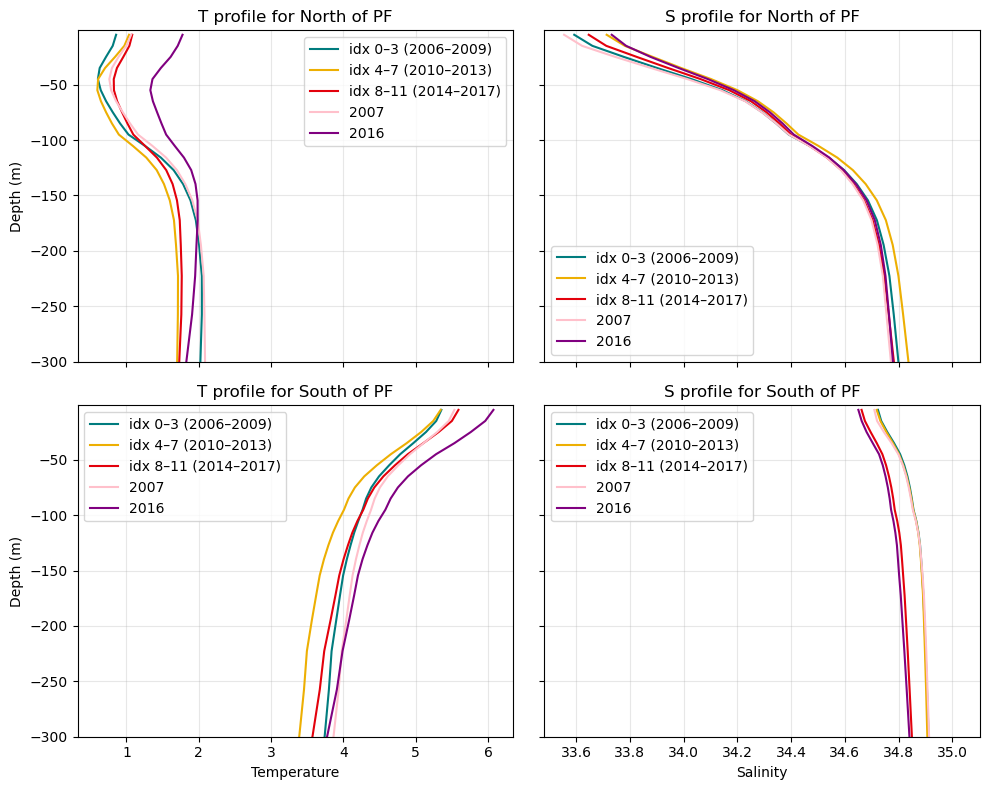

In [6]:

# group size
d = 4
years = np.asarray(allyears, dtype=int)

# make chunk edges: [(0,d), (d,2d), ..., (last chunk)]
edges = [(i, min(i+d, len(years))) for i in range(0, len(years), d)]

# colors (cycle if more chunks than colors)
c1, c2, c3 = '#007c7e', '#edaf02', '#e3010c'
color_cycle = [c1, c2, c3]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex='col', sharey=True)

for k, (i0, i1) in enumerate(edges):
    col = color_cycle[k % len(color_cycle)]

    # labels — show indices, and also years for clarity
    lab = f"idx {i0}–{i1-1} ({years[i0]}–{years[i1-1]})"
    # if you only want indices, use: lab = f"idx {i0}–{i1-1}"
    # if you only want years,   use: lab = f"{years[i0]}–{years[i1-1]}"

    # North of PF
    axes[0, 0].plot(np.nanmean(theta_distN[i0:i1], axis=(0, 1)), mygrid['RC'], label=lab, color=col)
    axes[0, 1].plot(np.nanmean(salt_distN[i0:i1],  axis=(0, 1)), mygrid['RC'], label=lab, color=col)


    # South of PF
    axes[1, 0].plot(np.nanmean(theta_distS[i0:i1], axis=(0, 1)), mygrid['RC'], label=lab, color=col)
    axes[1, 1].plot(np.nanmean(salt_distS[i0:i1],  axis=(0, 1)), mygrid['RC'], label=lab, color=col)

#also plot specifically for 2007 and 2016
axes[0, 0].plot(np.nanmean(theta_distN[1], axis=(0)), mygrid['RC'], label="2007", color="pink")
axes[0, 1].plot(np.nanmean(salt_distN[1],  axis=(0)), mygrid['RC'], label="2007", color="pink")
axes[0, 0].plot(np.nanmean(theta_distN[10], axis=(0)), mygrid['RC'], label="2016", color="purple")
axes[0, 1].plot(np.nanmean(salt_distN[10],  axis=(0)), mygrid['RC'], label="2016", color="purple")
axes[1, 0].plot(np.nanmean(theta_distS[1], axis=(0)), mygrid['RC'], label="2007", color="pink")
axes[1, 1].plot(np.nanmean(salt_distS[1],  axis=(0)), mygrid['RC'], label="2007", color="pink")
axes[1, 0].plot(np.nanmean(theta_distS[10], axis=(0)), mygrid['RC'], label="2016", color="purple")
axes[1, 1].plot(np.nanmean(salt_distS[10],  axis=(0)), mygrid['RC'], label="2016", color="purple")

# styling
for ax in axes.ravel():
    ax.set_ylim(-300, -1)
    ax.grid(alpha=0.3)
    ax.legend()

axes[0, 0].set_title("T profile for North of PF")
axes[0, 1].set_title("S profile for North of PF")
axes[1, 0].set_title("T profile for South of PF")
axes[1, 1].set_title("S profile for South of PF")

axes[1, 0].set_xlabel("Temperature")
axes[1, 1].set_xlabel("Salinity")
axes[0, 0].set_ylabel("Depth (m)")
axes[1, 0].set_ylabel("Depth (m)")

plt.tight_layout()
plt.show()


## let's also load the upper ocean heat and freshwater content for the two years

In [8]:
dterm = 10 # for 100m

In [9]:
# --- prep: make sure your masks are on C-grid (ny,nx) and are float with NaNs outside
mskN_C = np.where(mskN > 0, 1.0, np.nan).astype(float)
mskS_C = np.where(mskS > 0, 1.0, np.nan).astype(float)
msk_map = {"N": mskN_C, "S": mskS_C}

# Output arrays (per region)
heat_content = {k: np.full((len(allyears), 12, ny, nx), np.nan) for k in msk_map}  # J
fw_content   = {k: np.full((len(allyears), 12, ny, nx), np.nan) for k in msk_map}  # m

# Indices into fldList (discover once on first available timestep)
rec_ETAN = rec_THETADR = rec_SALTDR = None

sref = 34.8  # PSU
iy = 0
for year in allyears:
    print(int(year))

    # --- build monthly timesteps for this year
    times = {str(int(year)): np.arange(1, 13, 1)}
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)
    nT = len(tsstr)
    if nT == 0:
        print("  No timesteps found; skipping.")
        iy += 1
        continue

    # --- discover fldList rec indices once
    if rec_ETAN is None:
        meta2d = parsemeta(os.path.join(dirIn, f"budg2d_snap_set1.{tsstr[0]}.meta"))
        fld2d  = np.array(meta2d['fldList'])
        rec_ETAN = int(np.where(fld2d == 'ETAN')[0][0])

        meta3d = parsemeta(os.path.join(dirIn, f"budg3d_snap_set2.{tsstr[0]}.meta"))
        fld3d  = np.array(meta3d['fldList'])
        rec_THETADR = int(np.where(fld3d == 'THETADR')[0][0])
        rec_SALTDR  = int(np.where(fld3d == 'SALTDR')[0][0])

    # --- allocate and READ ONCE per year ---
    vol     = np.full((nT, nz, ny, nx), np.nan, dtype=float)  # m^3
    THETADR = np.full((nT, nz, ny, nx), np.nan, dtype=float)  # degC*m
    SALTDR  = np.full((nT, nz, ny, nx), np.nan, dtype=float)  # PSU*m

    # volume from ETAN (2D)
    for ti, ts in enumerate(tsstr):
        read = [int(ts)]
        ETAN, its, _ = rdmds(os.path.join(dirIn, 'budg2d_snap_set1'), read, returnmeta=True, rec=rec_ETAN)
        ETAN = np.reshape(ETAN, (ny, nx))

        tmpvol = np.zeros((nz, ny, nx), dtype=float)
        if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:
            tmpvol[0, :, :] = ETAN * myparms['rhoconst'] * RAC
            if myparms['useRFWF'] == 0:
                tmpvol[0, :, :] = 0.0
        else:
            # r* branch (keep your original logic)
            if myparms['useRFWF'] != 0:
                tmp1 = mk3D_mod(mygrid['DRF'], mygrid['hFacC']) * mygrid['hFacC']  # m
                tmp2 = tmp1 / mk3D_mod(DD, tmp1)
            else:
                tmp2 = drf3d / mk3D_mod(DD, tmp1)
            tmpvol = (tmp1 + tmp2 * mk3D_mod(ETAN, tmp2))

        vol[ti] = tmpvol

    # THETADR & SALTDR (3D)
    for ti, ts in enumerate(tsstr):
        read = [int(ts)]
        Tdr, its, _ = rdmds(os.path.join(dirIn, 'budg3d_snap_set2'), read, returnmeta=True, rec=rec_THETADR)
        Sdr, its, _ = rdmds(os.path.join(dirIn, 'budg3d_snap_set2'), read, returnmeta=True, rec=rec_SALTDR)
        THETADR[ti] = np.reshape(Tdr, (nz, ny, nx))
        SALTDR[ti]  = np.reshape(Sdr, (nz, ny, nx))

    # recover THETA, SALT safely
    THETA = np.full_like(THETADR, np.nan)
    SALT  = np.full_like(SALTDR,  np.nan)
    valid3 = (mygrid['hFacC'] > 0) & np.isfinite(DRF3d)
    valid3 = np.tile(valid3[np.newaxis,:,:,:],(12,1,1,1))
    DRF3d2 = np.tile(DRF3d[np.newaxis,:,:,:],(12,1,1,1))
    hfC2 = np.tile(mygrid['hFacC'][np.newaxis,:,:,:],(12,1,1,1))
    THETA[valid3] = THETADR[valid3] / (DRF3d2[valid3] * hfC2[valid3])
    SALT[valid3]  = SALTDR[valid3]  / (DRF3d2[valid3] * hfC2[valid3])

    # --- compute for BOTH masks without re-reading ---
    for ti in range(nT):
        # shared pieces
        theta_here = THETA[ti]                 # (nz, ny, nx)
        salt_here  = SALT[ti]
        vol_here   = vol[ti]                   # (nz, ny, nx)

        # Heat: (theta * rcp)[J/m^3] * vol[m^3] = J; then sum top dterm
        heat_J_layers = (theta_here * myparms['rcp']) * vol_here  # J
        heat_J_layers = heat_J_layers[:dterm]

        # FW content: FWvol[m^3] -> thickness[m] per layer, sum top dterm
        FWvol_layers = vol_here * (1.0 - salt_here / sref)        # m^3
        FWthk_layers = (FWvol_layers / RAC3)[:10]              # m

        for key, mask2d in msk_map.items():
            # apply 2D mask (1 inside, NaN outside)
            heat_map = np.nansum(heat_J_layers * mask2d, axis=0)      # (ny,nx) J
            fw_map   = np.nansum(FWthk_layers * mask2d, axis=0)       # (ny,nx) m

            heat_content[key][iy, ti] = heat_map
            fw_content[key][iy, ti]   = fw_map

    iy += 1


2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


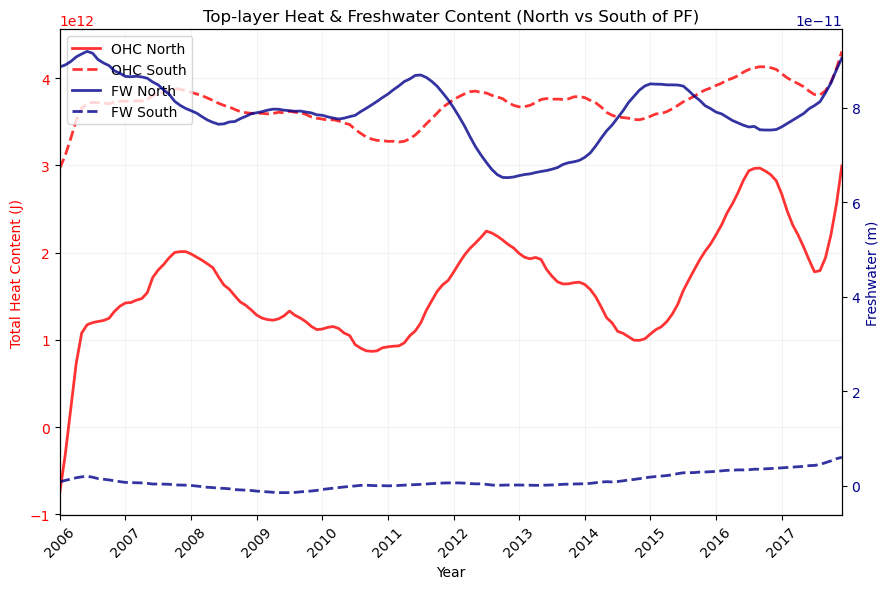

In [11]:
# Assumes you have (from earlier steps):
# heat_content["N"], heat_content["S"]  -> shape (nyears, 12, ny, nx), units: J per cell (already vertically integrated)
# fw_content["N"],   fw_content["S"]    -> shape (nyears, 12, ny, nx), units: m thickness per cell
# allyears (list/array of years)
# RAC (ny, nx)  -- only needed if you want area-weighted means or FW volumes

def series_from_maps(maps_yr_mon, how="sum", area=None):
    """
    Convert (nyears, 12, ny, nx) maps into a 1D monthly time series.
    how:
      - "sum": sum over space each month (e.g., total J over region for heat)
      - "area_mean": area-weighted mean over space each month (needs area)
      - "volume": sum(area * field) each month (e.g., FW volume in m^3; needs area)
    """
    tmap = maps_yr_mon.reshape(-1, maps_yr_mon.shape[-2], maps_yr_mon.shape[-1])  # (T, ny, nx)
    if how == "sum":
        return np.nansum(tmap, axis=(1, 2))
    elif how == "area_mean":
        if area is None: raise ValueError("area is required for area_mean")
        num = np.nansum(tmap * area[None, :, :], axis=(1, 2))
        den = np.nansum(np.where(np.isfinite(tmap), area[None, :, :], 0.0), axis=(1, 2))
        return num / np.where(den > 0, den, np.nan)
    elif how == "volume":
        if area is None: raise ValueError("area is required for volume")
        return np.nansum(tmap * area[None, :, :], axis=(1, 2))
    else:
        raise ValueError("Unknown 'how'")

# --- choose how you want the reduction over space ---
# For heat: total J over region makes sense -> "sum"
# For FW: mean thickness ("area_mean") OR total volume ("volume")
heat_how = "sum"
fw_how   = "area_mean"  # or "volume"

# Build monthly time series for both regions
heat_N = series_from_maps(heat_content["N"], how=heat_how, area=RAC)
heat_S = series_from_maps(heat_content["S"], how=heat_how, area=RAC)

fw_N   = series_from_maps(fw_content["N"],   how=fw_how,   area=RAC)
fw_S   = series_from_maps(fw_content["S"],   how=fw_how,   area=RAC)

# Smooth with 12-month rolling mean
window_size = 12
heat_N_sm = pd.Series(heat_N).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
heat_S_sm = pd.Series(heat_S).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
fw_N_sm   = pd.Series(fw_N).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
fw_S_sm   = pd.Series(fw_S).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

# Time axis from allyears
nyears = len(allyears); T = nyears * 12
time = np.arange(T)                          # monthly index
xtick_positions = np.arange(0, T, 12)        # every January
xtick_labels = np.asarray(allyears, dtype=int)

# Plot
fig, ax1 = plt.subplots(figsize=(9, 6))

# Heat (left axis): North solid, South dashed
ax1.plot(time, heat_N_sm, color="red", alpha=.8, lw=2, label="OHC North")
ax1.plot(time, heat_S_sm, color="red", alpha=.8, lw=2, ls="--", label="OHC South")
ax1.set_ylabel("Total Heat Content (J)", color="red")  # change to MJ/m² if you normalize by area
ax1.tick_params(axis='y', labelcolor="red")

# FW (right axis): North solid, South dashed
ax2 = ax1.twinx()
ax2.plot(time, fw_N_sm, color="darkblue", alpha=.8, lw=2, label="FW North")
ax2.plot(time, fw_S_sm, color="darkblue", alpha=.8, lw=2, ls="--", label="FW South")
ax2.set_ylabel("Freshwater (m)" if fw_how=="area_mean" else "Freshwater Volume (m³)", color="darkblue")
ax2.tick_params(axis='y', labelcolor="darkblue")

# Axes cosmetics
ax1.set_xlabel("Year")
ax1.set_title("Top-layer Heat & Freshwater Content (North vs South of PF)")
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)
ax1.set_xlim(0, T-1)
ax1.grid(alpha=0.15)

# # Equations (optional)
# eq1 = r"$F = \frac{S_{r} - S}{S_{r}}$"
# eq2 = r"$H = \rho C_p (T - T_{r})$"
# eq3 = r"$\bar{x}_i = \frac{1}{N} \sum_{j=i-k}^{i+k} x_j$"
# ax1.text(0.32, 0.92, eq1, transform=ax1.transAxes, fontsize=12, va='top', color='black')
# ax1.text(0.32, 0.85, eq2, transform=ax1.transAxes, fontsize=12, va='top', color='black')
# ax1.text(0.21, 0.76, "rolling average:", transform=ax1.transAxes, fontsize=12, va='top', color='black')
# ax1.text(0.32, 0.72, eq3, transform=ax1.transAxes, fontsize=12, va='top', color='black')

# Combined legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2, loc="upper left")

plt.tight_layout()
plt.show()


## Add the cross sections for T and S for the two regions

In [18]:
# do this by looping through the salt and heat -- we want to make an average of these as depth
# ArcWater = np.zeros((ntimes,nz,ny,nx))   # file to store True/False Arctic Water exists as a mask
# save the average T and S profiles with depth
ntimes = len(allyears)*12

thetaprofile_mskN = np.zeros((nz,ntimes))
thetaprofile_mskS = np.zeros((nz,ntimes))
saltprofile_mskN = np.zeros((nz,ntimes))
saltprofile_mskS = np.zeros((nz,ntimes))

# do indexing in years for the layers
iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    # read the fldList
    
    file_name = 'budg3d_snap_set2'
    meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg3d_snap_set2["fldList"])
    varnames = np.array(["THETADR","SALTDR"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
        
  
    for i in range(len(tsstr)):
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR = np.reshape(SALTDRi,(nz,ny,nx))

        # do for not subsect mask
        thisTHETA = THETADR/DRF3d/hfC * np.tile(mskN[np.newaxis,:,:],(nz,1,1))    # degC
        thisTHETA[thisTHETA == 0] = np.nan
        thetaprofile_mskN[:,iy] = np.nanmean(thisTHETA,axis=(1,2))
        thisTHETA = THETADR/DRF3d/hfC * np.tile(mskS[np.newaxis,:,:],(nz,1,1))    # degC
        thisTHETA[thisTHETA == 0] = np.nan
        thetaprofile_mskS[:,iy] = np.nanmean(thisTHETA,axis=(1,2))

        # do for not subsect mask
        thisSALT = SALTDR/DRF3d/hfC * np.tile(mskN[np.newaxis,:,:],(nz,1,1))      # PSU
        thisSALT[thisSALT == 0] = np.nan
        saltprofile_mskN[:,iy] = np.nanmean(thisSALT,axis=(1,2))
        thisSALT = SALTDR/DRF3d/hfC * np.tile(mskS[np.newaxis,:,:],(nz,1,1))      # PSU
        thisSALT[thisSALT == 0] = np.nan
        saltprofile_mskS[:,iy] = np.nanmean(thisSALT,axis=(1,2))
        
        iy += 1

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [19]:
# make a custom colormap
bounds = [-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4] # temperature bounds for the colormap
colors = ["#93c6dd","#b6d7e9","#d1e6f1","#f7f7f7","#fcefe8","#fedbc7","#f4a683","#e98366","#d75f4f","#b2172c","#8d0722","#66001e"]
len(colors)

12

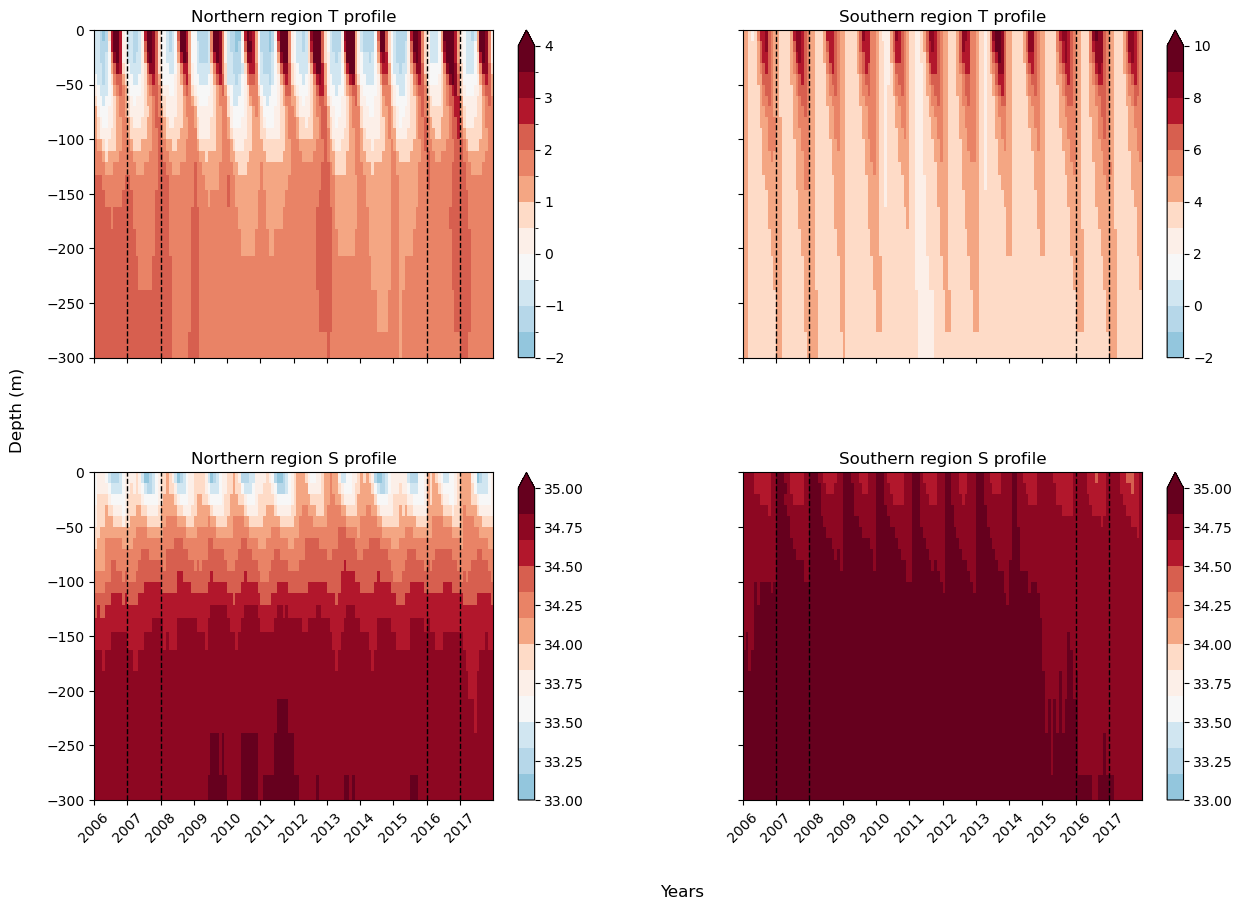

In [34]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

XVc, YVc = np.meshgrid(np.arange(145), mygrid['RF'])

cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

# Make a 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

# X ticks
xtick_positions = np.arange(0, 144, 12)  # Every 12 months
xtick_labels = np.arange(2006, 2018)     # Years from 2006 to 2017

# Find month indices for 2007 and 2016
year0 = 2006
x2007 = (2007 - year0) * 12   # = 12
x2008 = (2008 - year0) * 12   # = 12
x2016 = (2016 - year0) * 12   # = 120
x2017 = (2017 - year0) * 12   # = 120


# --- Temperature profiles ---
cb = axes[0,0].pcolormesh(XVc, YVc, thetaprofile_mskN, cmap=cmap, norm=norm)
axes[0,0].set_ylim(-300,0)
axes[0,0].set_title("Northern region T profile")
axes[0,0].set_xticks(xtick_positions)
axes[0,0].set_xticklabels(xtick_labels, rotation=45)
plt.colorbar(cb, ax=axes[0,0], extend="max")

cb = axes[0,1].pcolormesh(XVc, YVc, thetaprofile_mskS, cmap=cmap, vmin=-2, vmax=10)
axes[0,1].set_ylim(-300,0)
axes[0,1].set_title("Southern region T profile")
axes[0,1].set_xticks(xtick_positions)
axes[0,1].set_xticklabels(xtick_labels, rotation=45)
plt.colorbar(cb, ax=axes[0,1], extend="max")

# --- Salinity profiles ---
cb = axes[1,0].pcolormesh(XVc, YVc, saltprofile_mskN, cmap=cmap, vmin=33, vmax=35)
axes[1,0].set_ylim(-300,0)
axes[1,0].set_title("Northern region S profile")
axes[1,0].set_xticks(xtick_positions)
axes[1,0].set_xticklabels(xtick_labels, rotation=45)
plt.colorbar(cb, ax=axes[1,0], extend="max")

cb = axes[1,1].pcolormesh(XVc, YVc, saltprofile_mskS, cmap=cmap, vmin=33, vmax=35)
axes[1,1].set_ylim(-300,0)
axes[1,1].set_title("Southern region S profile")
axes[1,1].set_xticks(xtick_positions)
axes[1,1].set_xticklabels(xtick_labels, rotation=45)
plt.colorbar(cb, ax=axes[1,1], extend="max")

# Add dashed lines for 2007 and 2016
for ax in axes.flat:
    ax.axvline(x2007, color="k", linestyle="--", linewidth=1)
    ax.axvline(x2016, color="k", linestyle="--", linewidth=1)
    ax.axvline(x2008, color="k", linestyle="--", linewidth=1)
    ax.axvline(x2017, color="k", linestyle="--", linewidth=1)

# Labels and layout
fig.supxlabel("Years")
fig.supylabel("Depth (m)")
fig.subplots_adjust(left=0.08, wspace=0.3, hspace=0.35)

# plt.savefig(path + "TS_profiles_with_year_lines.png", dpi=300)
plt.show()


## We should also add to the above the BSO heat transport and sea ice extent as a bi-axis grid